In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import label_binarize
import datetime

class TrashNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, d)) and d != 'checkpoints'])
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

    def get_class_names(self):
        return self.classes

class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class TrashNetResNet(nn.Module):
    def __init__(self, num_classes):
        super(TrashNetResNet, self).__init__()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)
        self.model = resnet

    def forward(self, x):
        return self.model(x)

In [ ]:
def set_device(preferred_device='auto'):
    if preferred_device == 'cpu':
        return torch.device('cpu')
    elif preferred_device == 'cuda':
        return torch.device('cuda')
    else:
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def prepare_data(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = TrashNetDataset(root_dir=data_dir, transform=transform)

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, dataset.get_class_names()

def plot_loss_curves(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'./{model_name}_loss_curves.png')
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, class_names, model_name):
    plt.figure(figsize=(12, 8))

    # Individual class ROC curves
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], alpha=0.3, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})',
             color='blue', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(f'./{model_name}_roc_curves.png')
    plt.show()

def calculate_metrics(y_true, y_pred, y_pred_proba, class_names):
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                             average=None,
                                                             labels=range(len(class_names)))
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                                               average='macro',
                                                                               labels=range(len(class_names)))
    accuracy = accuracy_score(y_true, y_pred)

    print("\nDetailed Classification Metrics:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nMetrics for each class:")

    for i, class_name in enumerate(class_names):
        if i < len(precision):
            print(f"\n{class_name}:")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-score: {f1[i]:.4f}")
        else:
            print(f"\n{class_name}: No predictions for this class")

    print("\nMacro-averaged metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1-score: {macro_f1:.4f}")

    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'class_precision': precision,
        'class_recall': recall,
        'class_f1': f1
    }



def train_model(model, train_loader, val_loader, device, epochs=8, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    os.makedirs('./checkpoints', exist_ok=True)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            checkpoint_path = f'./checkpoints/{model.__class__.__name__}_best.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            }, checkpoint_path)
            print(f'New best model saved at: {checkpoint_path}')

        scheduler.step(avg_val_loss)

    plot_loss_curves(train_losses, val_losses, model.__class__.__name__)
    model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)

    metrics = calculate_metrics(all_labels, all_predictions, all_probabilities, class_names)
    plot_roc_curves(all_labels, all_probabilities, class_names, model.__class__.__name__)

    plt.figure(figsize=(12, 8))
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    for t, p in zip(all_labels, all_predictions):
        confusion_matrix[t, p] += 1

    confusion_matrix_proportions = confusion_matrix / confusion_matrix.sum(dim=1, keepdim=True)

    im = plt.imshow(confusion_matrix_proportions, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = confusion_matrix[i, j].item()
            prop = confusion_matrix_proportions[i, j].item()
            text = f'{prop*100:.1f}%\n({int(count)})'
            color = 'white' if prop > 0.5 else 'black'
            plt.text(j, i, text, ha="center", va="center", color=color)

    plt.title('Confusion Matrix\n(Percentages by True Class)', pad=20)
    class_totals = confusion_matrix.sum(dim=1)
    y_labels = [f'{class_names[i]}\n{class_totals[i]:.0f} samples' for i in range(len(class_names))]

    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), y_labels)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'./{model.__class__.__name__}_confusion_matrix.png')
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Deep_Learning/data'

/content/drive/MyDrive/Deep_Learning/data


In [ ]:
ls

BaselineCNN_confusion_matrix.png  glass/    TrashNetResNet_confusion_matrix.png
BaselineCNN_loss_curves.png       metal/    TrashNetResNet_loss_curves.png
BaselineCNN_roc_curves.png        paper/    TrashNetResNet_roc_curves.png
cardboard/                        plastic/
checkpoints/                      trash/


Epoch 1/8
Train Loss: 7.5430, Train Accuracy: 44.85%
Val Loss: 2.6548, Val Accuracy: 45.38%
New best model saved at: ./checkpoints/BaselineCNN_best.pth
Epoch 2/8
Train Loss: 2.1580, Train Accuracy: 49.77%
Val Loss: 1.3958, Val Accuracy: 57.78%
New best model saved at: ./checkpoints/BaselineCNN_best.pth
Epoch 3/8
Train Loss: 1.4476, Train Accuracy: 54.52%
Val Loss: 1.2148, Val Accuracy: 62.53%
New best model saved at: ./checkpoints/BaselineCNN_best.pth
Epoch 4/8
Train Loss: 1.1684, Train Accuracy: 59.84%
Val Loss: 1.3995, Val Accuracy: 59.63%
Epoch 5/8
Train Loss: 1.1164, Train Accuracy: 60.80%
Val Loss: 1.2554, Val Accuracy: 65.17%
Epoch 6/8
Train Loss: 1.0902, Train Accuracy: 63.29%
Val Loss: 1.2086, Val Accuracy: 64.12%
New best model saved at: ./checkpoints/BaselineCNN_best.pth
Epoch 7/8
Train Loss: 1.1068, Train Accuracy: 64.71%
Val Loss: 1.2745, Val Accuracy: 64.91%
Epoch 8/8
Train Loss: 1.0180, Train Accuracy: 66.29%
Val Loss: 1.2499, Val Accuracy: 64.64%


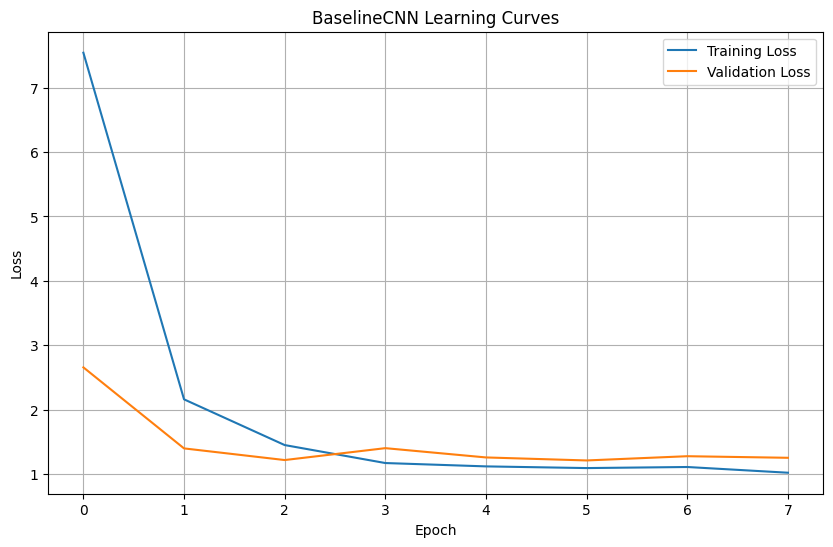


Detailed Classification Metrics:
Overall Accuracy: 0.6263

Metrics for each class:

cardboard:
Precision: 0.7963
Recall: 0.7288
F1-score: 0.7611

glass:
Precision: 0.4639
Recall: 0.5769
F1-score: 0.5143

metal:
Precision: 0.5091
Recall: 0.4590
F1-score: 0.4828

paper:
Precision: 0.8298
Recall: 0.8478
F1-score: 0.8387

plastic:
Precision: 0.5694
Recall: 0.6212
F1-score: 0.5942

trash:
Precision: 0.3750
Recall: 0.1250
F1-score: 0.1875

Macro-averaged metrics:
Precision: 0.5906
Recall: 0.5598
F1-score: 0.5631


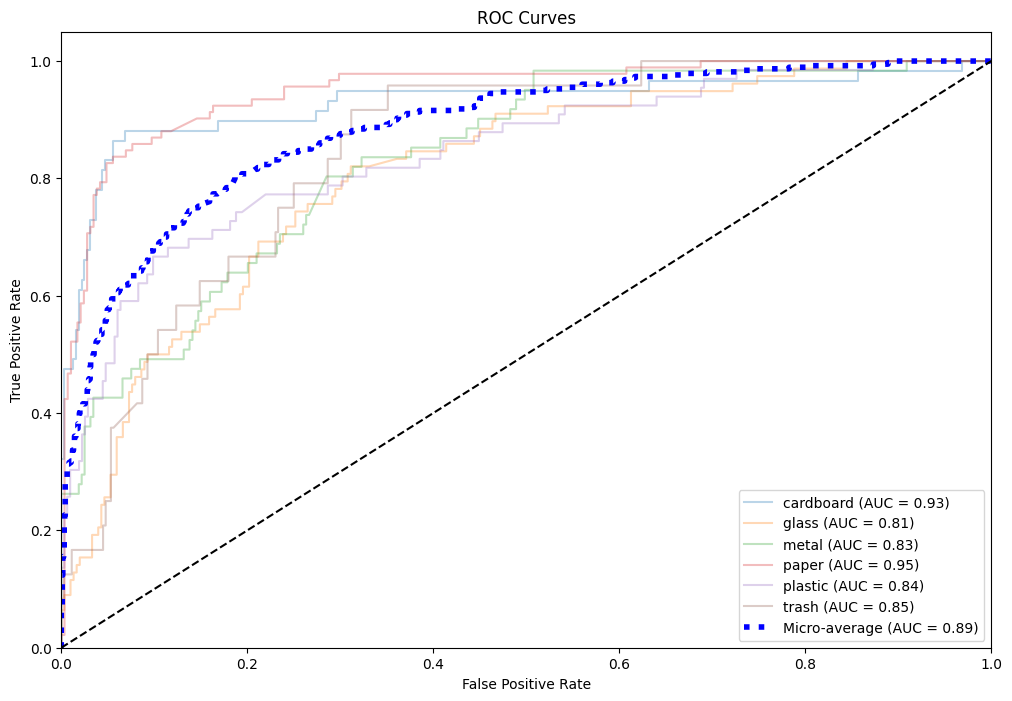

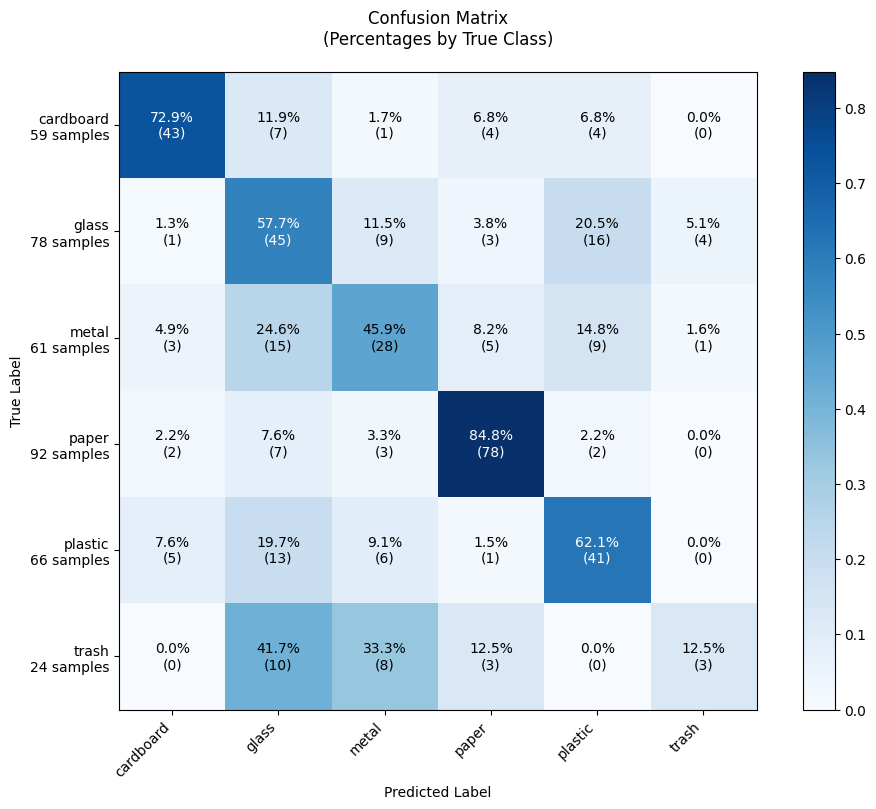

In [ ]:

# Example usage:
device = set_device('auto')
train_loader, val_loader, test_loader, class_names = prepare_data('/content/drive/MyDrive/Deep_Learning/data')

# For Baseline CNN
baseline_model = BaselineCNN(num_classes=len(class_names))
trained_baseline = train_model(baseline_model, train_loader, val_loader, device)
evaluate_model(trained_baseline, test_loader, device, class_names)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8
Train Loss: 0.7035, Train Accuracy: 74.43%
Val Loss: 0.4059, Val Accuracy: 85.22%
New best model saved at: ./checkpoints/TrashNetResNet_best.pth
Epoch 2/8
Train Loss: 0.1616, Train Accuracy: 96.44%
Val Loss: 0.2936, Val Accuracy: 90.50%
New best model saved at: ./checkpoints/TrashNetResNet_best.pth
Epoch 3/8
Train Loss: 0.0508, Train Accuracy: 99.43%
Val Loss: 0.2827, Val Accuracy: 90.77%
New best model saved at: ./checkpoints/TrashNetResNet_best.pth
Epoch 4/8
Train Loss: 0.0230, Train Accuracy: 99.89%
Val Loss: 0.2696, Val Accuracy: 89.97%
New best model saved at: ./checkpoints/TrashNetResNet_best.pth
Epoch 5/8
Train Loss: 0.0169, Train Accuracy: 99.83%
Val Loss: 0.2779, Val Accuracy: 90.77%
Epoch 6/8
Train Loss: 0.0125, Train Accuracy: 99.89%
Val Loss: 0.2687, Val Accuracy: 91.29%
New best model saved at: ./checkpoints/TrashNetResNet_best.pth
Epoch 7/8
Train Loss: 0.0125, Train Accuracy: 99.77%
Val Loss: 0.2716, Val Accuracy: 91.29%
Epoch 8/8
Train Loss: 0.0095, Train Accur

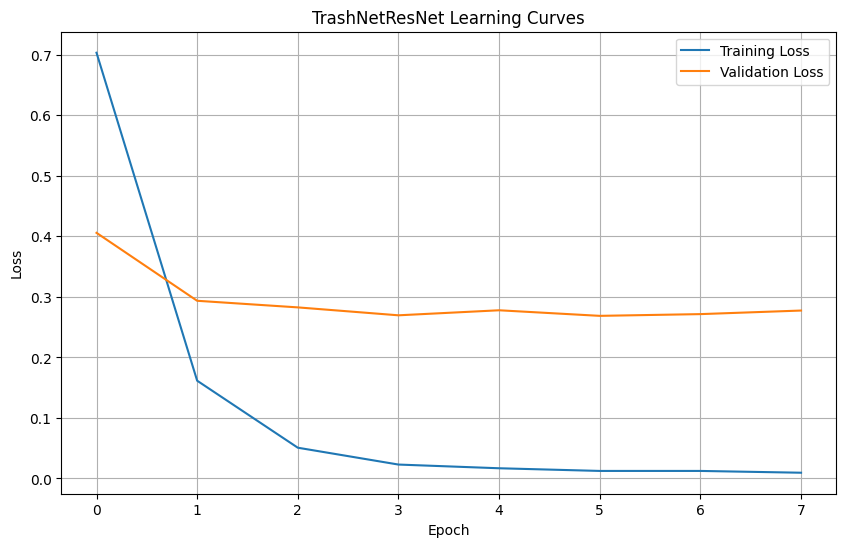


Detailed Classification Metrics:
Overall Accuracy: 0.9211

Metrics for each class:

cardboard:
Precision: 0.9655
Recall: 0.9492
F1-score: 0.9573

glass:
Precision: 0.9200
Recall: 0.8846
F1-score: 0.9020

metal:
Precision: 0.8485
Recall: 0.9180
F1-score: 0.8819

paper:
Precision: 0.9474
Recall: 0.9783
F1-score: 0.9626

plastic:
Precision: 0.9206
Recall: 0.8788
F1-score: 0.8992

trash:
Precision: 0.9130
Recall: 0.8750
F1-score: 0.8936

Macro-averaged metrics:
Precision: 0.9192
Recall: 0.9140
F1-score: 0.9161


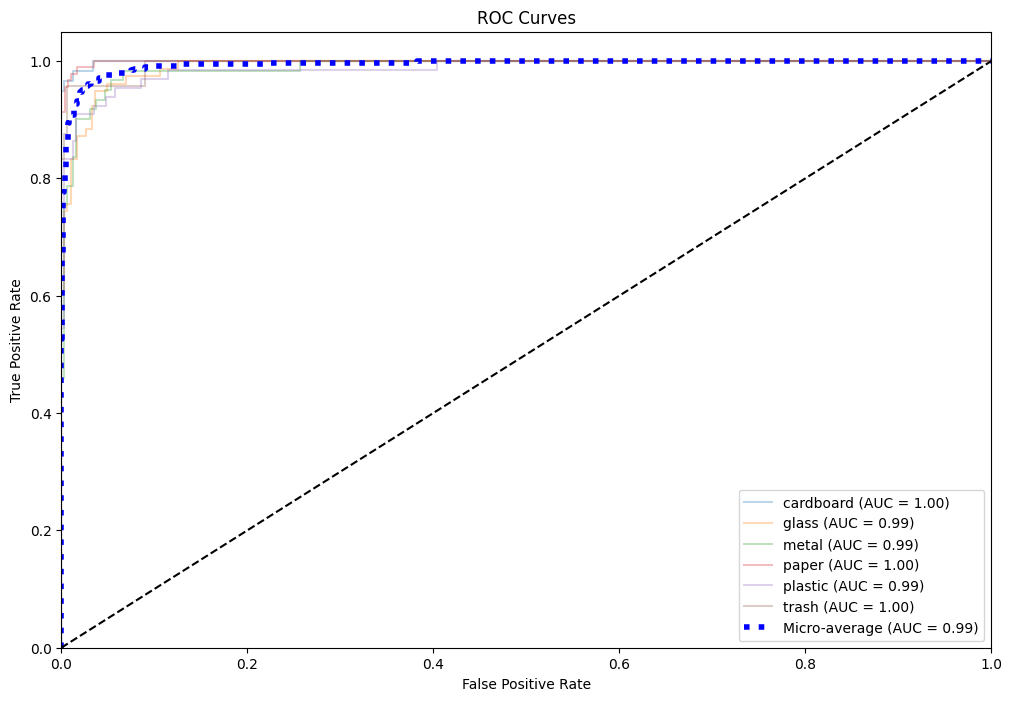

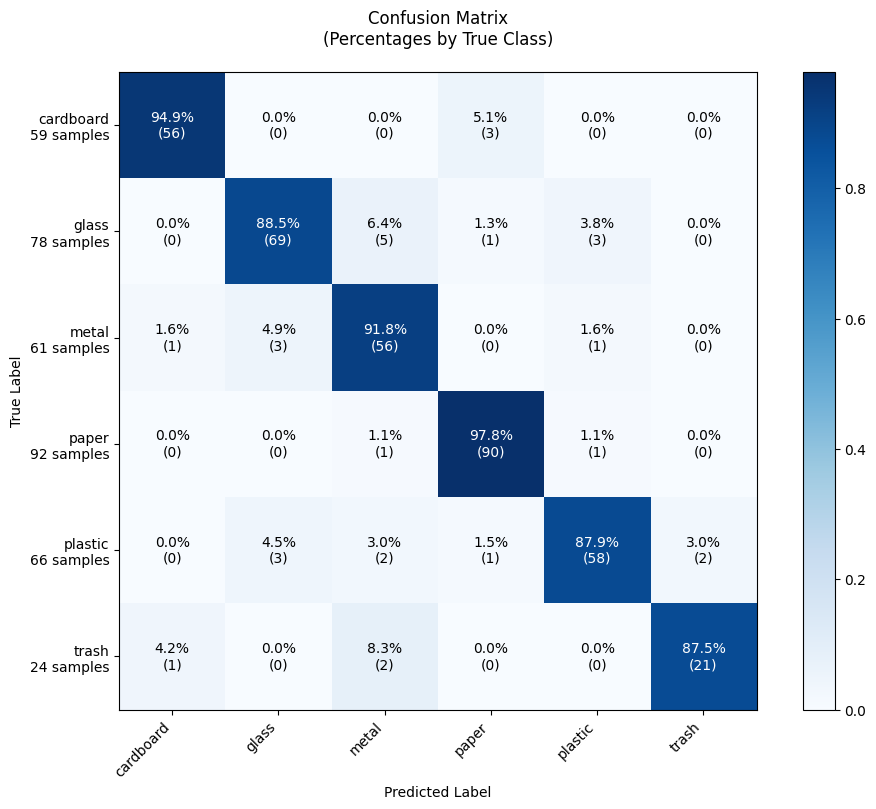

In [ ]:
# For ResNet
resnet_model = TrashNetResNet(num_classes=len(class_names))
trained_resnet = train_model(resnet_model, train_loader, val_loader, device, learning_rate=0.0001)
evaluate_model(trained_resnet, test_loader, device, class_names)